# Required Libraries

In [1]:
import kagglehub
import pandas as pd
import numpy as np
import seaborn as sns
import re
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from umap import UMAP
import warnings
import random
warnings.filterwarnings("ignore")

random.seed(1000)


pd.set_option("display.max_columns", 100)
path = kagglehub.dataset_download("imakash3011/customer-personality-analysis")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'customer-personality-analysis' dataset.
Path to dataset files: /kaggle/input/customer-personality-analysis


#Exploratory Data Analysis

In [2]:
# LOAD DATA
df = pd.read_csv(f"{path}/marketing_campaign.csv", sep = '\t')
print("Shape:", df.shape)   # .shape returns the (rows, columns) of the DataFrame
df.head()   # shows first 5 rows of df

Shape: (2240, 29)


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

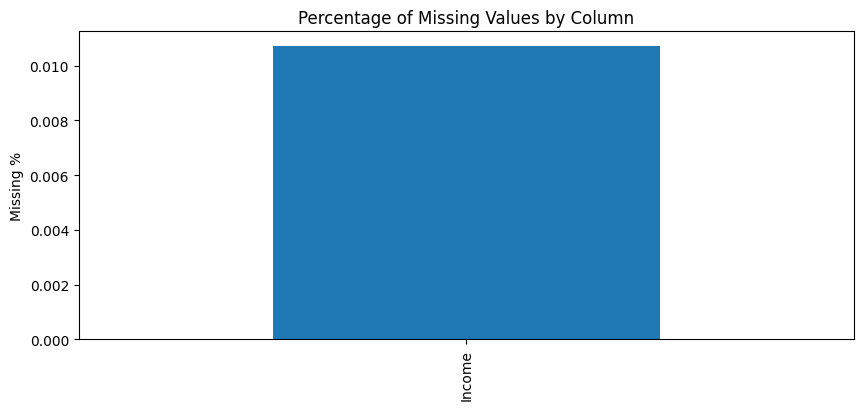

In [3]:
# DATA ORIENTATION
df.info()   # gives structural summary of df
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
cat_cols = df.select_dtypes(include=["object"]).columns.tolist()
print("Numeric columns:", numeric_cols)
print("Categorical/Text columns:", cat_cols)

# MISSING DATA ANALYSIS
missing_pct = df.isnull().mean().sort_values(ascending=False) # sorted columns by percentage of missing values
missing_pct[missing_pct > 0]

plt.figure(figsize=(10,4))    # creates new figure to display plot
missing_pct[missing_pct > 0].plot(kind="bar")
plt.title("Percentage of Missing Values by Column")
plt.ylabel("Missing %")
plt.grid(False)
plt.show()

In [4]:
# Impute small missing values
df['Income'] = df['Income'].fillna(df['Income'].median())   # imputes missing values using median of column

# Convert date column
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], dayfirst=True)

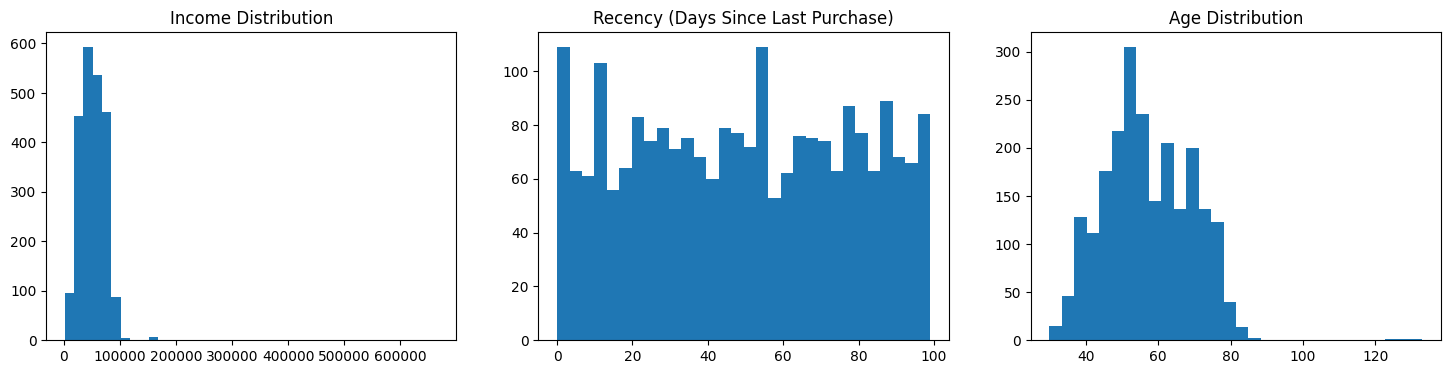

In [5]:
# UNIVARIATE EDA
# Numeric
df[numeric_cols].describe().T

# Calculate Age before using it
df['Age'] = pd.Timestamp.now().year - df['Year_Birth'] # always better to have Age than birth year

fig, axes = plt.subplots(1, 3, figsize=(18,4))

df['Income'].hist(bins=40, ax=axes[0], grid = False)
axes[0].set_title("Income Distribution")

df['Recency'].hist(bins=30, ax=axes[1], grid = False)
axes[1].set_title("Recency (Days Since Last Purchase)")

df['Age'].hist(bins=30, ax=axes[2], grid = False)
axes[2].set_title("Age Distribution")

plt.show()

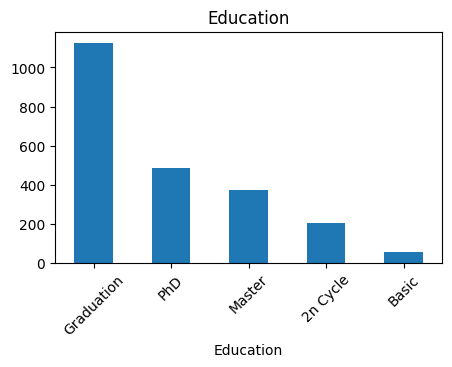

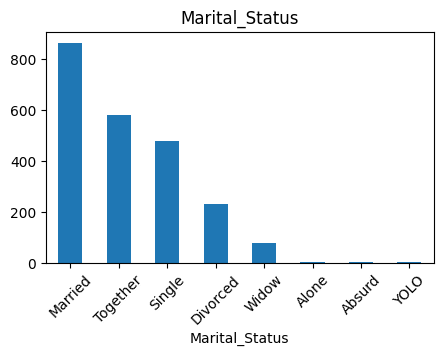

In [6]:
# Categorical
for col in ['Education', 'Marital_Status']:
    plt.figure(figsize=(5,3))
    df[col].value_counts().plot(kind='bar')
    plt.xticks(rotation = 45)
    plt.title(col)
    plt.grid(False)
    plt.show()

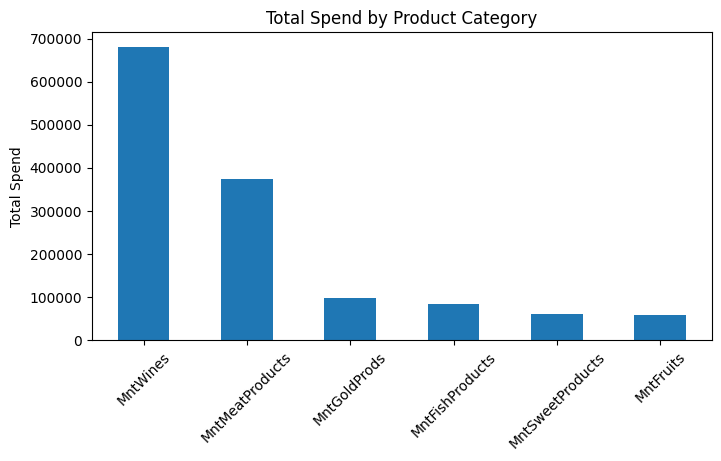

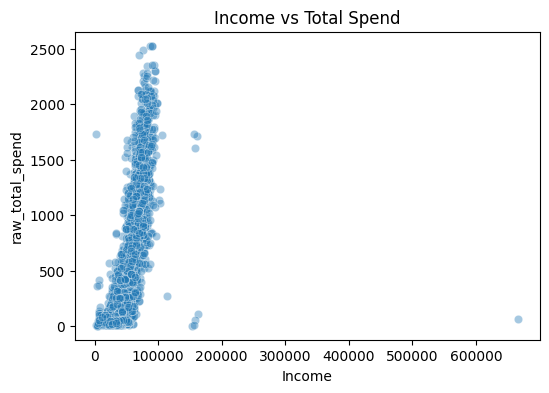

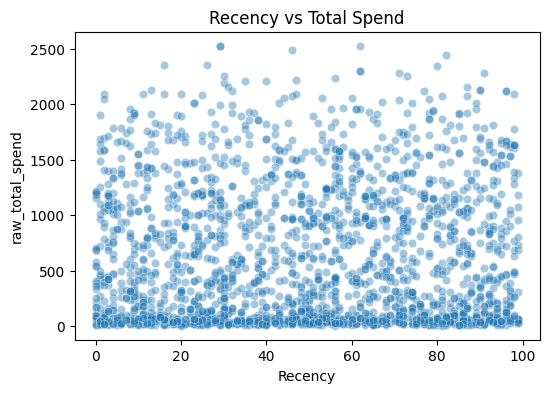

In [7]:
# SPENDING EDA
spend_cols = [
    'MntWines','MntFruits','MntMeatProducts',
    'MntFishProducts','MntSweetProducts','MntGoldProds'
]
df['raw_total_spend'] = df[spend_cols].sum(axis=1)

df[spend_cols].sum().sort_values(ascending=False).plot(kind="bar", figsize=(8,4), grid = False)
plt.title("Total Spend by Product Category")
plt.ylabel("Total Spend")
plt.xticks(rotation = 45)
plt.show()

# Uncomment the line below to remove the high-income outlier for clearer visualization
#plot_df = df[df['Income'] < df['Income'].quantile(0.99)]

plt.figure(figsize=(6,4))
sns.scatterplot(x='Income', y='raw_total_spend', data=df, alpha=0.4)  # Change df to plot_df after uncommenting
plt.title("Income vs Total Spend")
plt.grid(False)
plt.show()

plt.figure(figsize=(6,4))
sns.scatterplot(x='Recency', y='raw_total_spend', data=df, alpha=0.4)
plt.title("Recency vs Total Spend")
plt.grid(False)
plt.show()

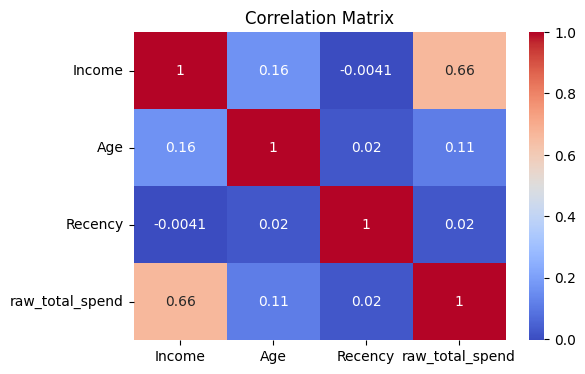

In [8]:
# MULTIVARIATE ANALYSIS
corr_features = ['Income', 'Age', 'Recency', 'raw_total_spend']
plt.figure(figsize=(6,4))
sns.heatmap(df[corr_features].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

# Feature Engineering

In [9]:
# Kidhome and Teenhome separately don't tell you total household burden. The model has to infer family size indirectly.
df['household_size'] = 1 + df['Kidhome'] + df['Teenhome']

# Total spend across all product categories (overall customer value) instead of 6 unrelated numbers
df['total_spend'] = df[spend_cols].sum(axis=1)

# Share of spend per category
for col in spend_cols:
    df[f'{col}_share'] = df[col] / (df['total_spend'] + 1)  # +1 added to denominator to avoid division by zero

# Gives context to the customers activity baseline
df['total_purchases'] = df['NumWebPurchases'] + df['NumCatalogPurchases'] + df['NumStorePurchases']

# Channel purchase ratios
# Note that raw channel counts correlate heavily with income, tenure and overall activity, so this engineering enables
# clean segmentation and better generalization across different levels of income
df['web_purchase_ratio'] = df['NumWebPurchases'] / (df['total_purchases'] + 1)
df['store_purchase_ratio'] = df['NumStorePurchases'] / (df['total_purchases'] + 1)
df['catalog_purchase_ratio'] = df['NumCatalogPurchases'] / (df['total_purchases'] + 1)

# Captures price sensitivity, promotion responsiveness and campaign elasticity
df['deal_intensity'] = df['NumDealsPurchases'] / (df['total_purchases'] + 1)

# Improves clustering and supervised response models because it separates recency effects from loyal or stable customers,
# which is something that just the date doesn't give
df['customer_tenure_days'] = (pd.Timestamp.today() - df['Dt_Customer']).dt.days

# Select features for clustering
engineered_features = [
    'Income', 'household_size', 'total_spend', 'web_purchase_ratio',
    'store_purchase_ratio', 'catalog_purchase_ratio', 'deal_intensity',
    'Recency', 'customer_tenure_days'
]
df_cluster_ready = df[engineered_features].copy()

In [10]:
categorical_cols = ['Education', 'Marital_Status']  # low-cardinality example
encode_categorical = True

if encode_categorical:
    # One-hot encoding avoids model assuming ordinal relationship
    df_cat_encoded = pd.get_dummies(df[categorical_cols], prefix=categorical_cols)
    engineered_features.extend(df_cat_encoded.columns.tolist())
    df = pd.concat([df, df_cat_encoded], axis=1)

In [11]:
# OPTIONAL: since we're using LLM based textual analysis which is superior- To try set encode_text to True and have values ready
# No natural text column in this dataset but if you have survey or feedback text, this is a TF-IDF example

encode_text = False

if encode_text:
    if 'Feedback' in df.columns:
        tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=50)
        X_text = tfidf_vectorizer.fit_transform(df['Feedback'].fillna(''))
    else:
        print("No text column found, skipping text encoding")

# Supervised Learning

In [12]:
# Predict whether a customer responded to a campaign (AcceptedCmp1)
target = 'AcceptedCmp1'
features = engineered_features + ['Age']

X = df[features].fillna(0)
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1000)


In [13]:
# Logistic Regression

# scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# call the logistic regression model
lr = LogisticRegression()
lr.fit(X_train_scaled, y_train)
y_pred = lr.predict(X_test_scaled)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Logistic Regression Accuracy: 0.9397321428571429
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       425
           1       0.00      0.00      0.00        23

    accuracy                           0.94       448
   macro avg       0.47      0.50      0.48       448
weighted avg       0.90      0.94      0.92       448



In [14]:
# Random Forest

rf = RandomForestClassifier(n_estimators=100, random_state=1000)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

Random Forest Accuracy: 0.953125
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       425
           1       0.62      0.22      0.32        23

    accuracy                           0.95       448
   macro avg       0.79      0.61      0.65       448
weighted avg       0.94      0.95      0.94       448



In [15]:
# Linear Regression

from sklearn.linear_model import LinearRegression
target_reg = 'total_spend'

# Feature set (exclude total_spend from features to prevent data leakage)
features_reg = [f for f in engineered_features + ['Age'] if f != 'total_spend']

X_reg = df[features_reg].fillna(0)
y_reg = df[target_reg]

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=1000)

scaler_reg = StandardScaler()
X_train_reg_scaled = scaler_reg.fit_transform(X_train_reg)
X_test_reg_scaled = scaler_reg.transform(X_test_reg)

lr_reg = LinearRegression()
lr_reg.fit(X_train_reg_scaled, y_train_reg)

y_pred_reg = lr_reg.predict(X_test_reg_scaled)

print("Linear Regression R2 Score:", lr_reg.score(X_test_reg_scaled, y_test_reg)) # features explain ~71% of the variance in total_spend
print("Linear Regression RMSE:", np.sqrt(np.mean((y_test_reg - y_pred_reg)**2))) # on average predictions deviate by ~$323 from the actual spend
print("Linear Regression MAE:", np.mean(np.abs(y_test_reg - y_pred_reg))) # median-ish error

Linear Regression R2 Score: 0.7286003258410843
Linear Regression RMSE: 309.9864509358606
Linear Regression MAE: 229.0195181495033


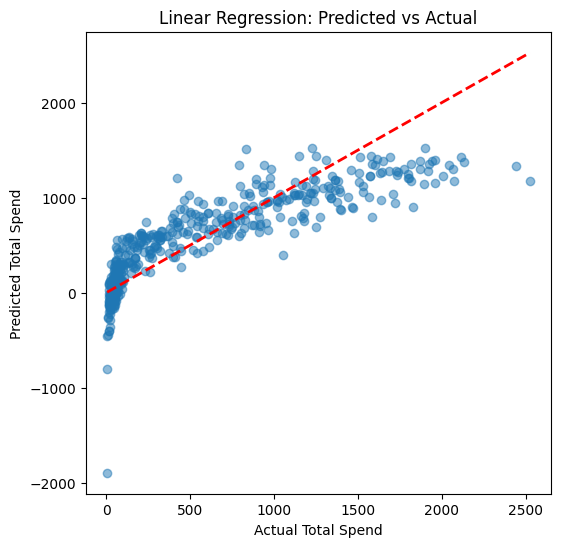

In [16]:
plt.figure(figsize=(6,6))
plt.scatter(y_test_reg, y_pred_reg, alpha=0.5)
plt.plot([y_test_reg.min(), y_test_reg.max()],
         [y_test_reg.min(), y_test_reg.max()],
         'r--', lw=2)
plt.xlabel("Actual Total Spend")
plt.ylabel("Predicted Total Spend")
plt.title("Linear Regression: Predicted vs Actual")
plt.grid(False)
plt.show()

In [17]:
# Optional -  Uncomment to try

'''
from xgboost import XGBClassifier

xgb = XGBClassifier(n_estimators=100, learning_rate=0.1, eval_metric='logloss', random_state=1000)
xgb.fit(X_train_scaled, y_train)

y_pred_xgb = xgb.predict(X_test_scaled)

print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))
'''

'\nfrom xgboost import XGBClassifier\n\nxgb = XGBClassifier(n_estimators=100, learning_rate=0.1, eval_metric=\'logloss\', random_state=1000)\nxgb.fit(X_train_scaled, y_train)\n\ny_pred_xgb = xgb.predict(X_test_scaled)\n\nprint("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))\nprint(classification_report(y_test, y_pred_xgb))\n'

In [18]:
# Optional - Uncomment to try

'''
from sklearn.svm import SVC

svm_model = SVC(kernel='rbf', probability=True)
svm_model.fit(X_train_scaled, y_train)

y_pred_svm = svm_model.predict(X_test_scaled)

print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))
'''

'\nfrom sklearn.svm import SVC\n\nsvm_model = SVC(kernel=\'rbf\', probability=True)\nsvm_model.fit(X_train_scaled, y_train)\n\ny_pred_svm = svm_model.predict(X_test_scaled)\n\nprint("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))\nprint(classification_report(y_test, y_pred_svm))\n'

#Unsupervised Learning

It is important to note that the following unsupervised learning techniques do not work well on categorical (nominal) data.

However, if the feature is categorical (ordinal) then there are some ways that you can handle it, such as:


1.   Binary Encoding
2.   Ordinal Encoding
3.   Rank Normalisation



In [19]:
# Filter out customers from the data frame that accepted the offer at the first campaign
new_df = df[df['AcceptedCmp1'] == 1]

# drop all categorical features
new_df = new_df.drop(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Dt_Customer', 'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Complain'], axis =1)

# scale the features
scaler = StandardScaler()
new_df = pd.DataFrame(scaler.fit_transform(new_df), columns = new_df.columns)

new_df.head()

,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Z_CostContact,Z_Revenue,Response,Age,raw_total_spend,household_size,total_spend,MntWines_share,MntFruits_share,MntMeatProducts_share,MntFishProducts_share,MntSweetProducts_share,MntGoldProds_share,total_purchases,web_purchase_ratio,store_purchase_ratio,catalog_purchase_ratio,deal_intensity,customer_tenure_days,Education_2n Cycle,Education_Basic,Education_Graduation,Education_Master,Education_PhD,Marital_Status_Absurd,Marital_Status_Alone,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow,Marital_Status_YOLO
0,0.369237,-0.272315,-0.485383,-0.847862,0.744245,-0.613735,-1.214431,-0.449912,0.052240,-0.495132,-0.304855,0.585484,-0.038746,1.463446,-0.262435,0.0,0.0,0.907075,1.671283,-0.330729,-0.487566,-0.330729,1.331149,-0.577996,-1.349015,-0.328159,0.200036,-0.431104,1.135759,-0.075765,0.816125,-0.566406,-0.442401,1.298483,-0.328165,0.0,-1.150035,-0.377964,1.949359,-0.083624,0.0,-0.301511,-0.881917,1.909231,-0.534522,-0.189661,0.0
1,-0.128170,-0.272315,1.769300,1.556500,0.762295,0.437950,0.245300,-1.257700,-0.897202,1.523490,0.426798,2.428318,-0.835812,0.348440,0.719140,0.0,0.0,-1.102445,1.448789,0.592895,1.108106,0.592895,0.256603,0.290870,-0.018581,-1.254911,-0.917080,0.818518,0.913545,1.780947,-0.265462,-1.260295,0.047808,0.676632,-0.328165,0.0,-1.150035,2.645751,-0.512989,-0.083624,0.0,-0.301511,1.133893,-0.523771,-0.534522,-0.189661,0.0
2,0.350558,-0.272315,-0.485383,0.248244,-0.747880,1.163250,0.443488,0.878146,-0.458998,2.525096,-0.304855,-0.796642,1.156852,-0.394898,-1.244011,0.0,0.0,0.907075,-0.627826,0.266561,-0.487566,0.266561,-1.121023,1.195125,0.401663,0.738118,-0.505057,1.791618,0.024690,-0.932036,-0.549515,1.373033,-0.334330,-1.509876,-0.328165,0.0,0.869539,-0.377964,-0.512989,-0.083624,0.0,3.316625,-0.881917,-0.523771,-0.534522,-0.189661,0.0
3,0.831427,-0.272315,1.769300,-0.989295,-0.212400,-0.758795,-0.475037,1.494256,-0.751134,-0.602997,-0.304855,2.428318,1.555385,0.720109,0.719140,0.0,0.0,0.907075,-0.776155,-0.411818,1.108106,-0.411818,0.103901,-0.755064,-0.274740,2.003856,-0.659376,-0.516147,2.469042,0.734455,-0.771431,0.234959,-0.527507,-1.108682,3.047247,0.0,-1.150035,-0.377964,-0.512989,-0.083624,0.0,-0.301511,-0.881917,1.909231,-0.534522,-0.189661,0.0
4,-2.408015,-0.272315,1.769300,-1.555027,-1.403694,-0.903855,-1.511713,-1.257700,-1.134562,-0.664634,1.890103,0.124775,-2.031410,-0.766567,1.700716,0.0,0.0,0.907075,0.855470,-2.195778,1.108106,-2.195778,1.431609,-0.597488,-1.267147,-1.254911,-0.941432,0.672139,-1.530806,1.656688,0.464960,-2.128733,2.475509,-1.459727,-0.328165,0.0,0.869539,-0.377964,-0.512989,-0.083624,0.0,-0.301511,-0.881917,1.909231,-0.534522,-0.189661,0.0


KMeans Clustering

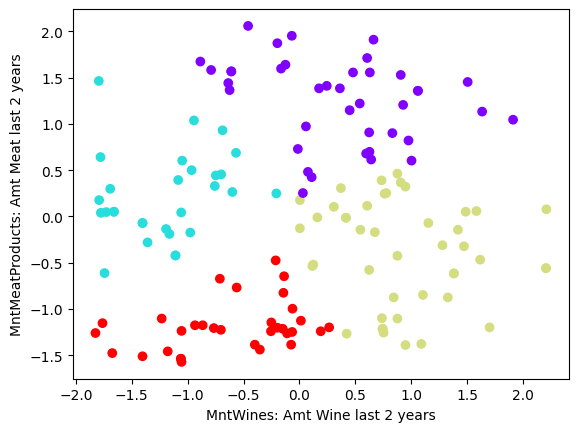

In [20]:
from sklearn.cluster import KMeans

# do a KMeans cluster on a 2D graph using MntWines and MntMeatProducts as my axis
kmeans = KMeans(n_clusters=4, random_state=1000)
kmeans.fit(new_df[['MntWines','MntMeatProducts']])

# plot the graph
plt.scatter(new_df['MntWines'], new_df['MntMeatProducts'], c=kmeans.labels_, cmap='rainbow')
plt.xlabel("MntWines: Amt Wine last 2 years")
plt.ylabel("MntMeatProducts: Amt Meat last 2 years")
plt.grid(False)
plt.show()

Here we demonstrate using the elbow method to choose the number of clusters that you should choose for kmeans.

However, other valid methods for choosing the appropriate k:


1.   Visually
2.   BIC (Bayesian Information Criterion)
3.   BICc (Bayesian Information Criterion Corrected)
4.   AIC (Akaike Information Criterion)
5.   AICc (Akaike Information Criterion Corrected)



The elbow point in this case is not very distinct, though choosing 4 or 5 clusters appears reasonable. When the elbow is ambiguous, additional validation methods (e.g. BIC or domain knowledge) can be used to support the decision. Ultimately, the “optimal” number of clusters depends on the analysis objective, not just the metric.

Intuitive sanity check approach:

1. Fit clustering models with k = 4 and k = 5

2. Assign cluster labels and perform exploratory data analysis (EDA) on each result

3. Compare the cluster profiles to assess whether the additional cluster provides meaningfully different insights

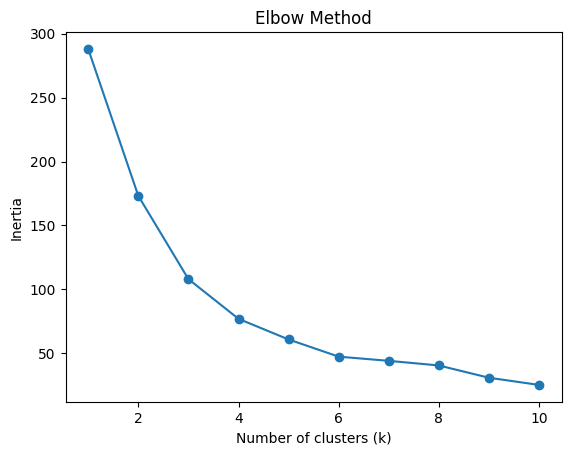

In [21]:
# Range of k values to test
k_values = range(1, 11)

inertia = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=1000)
    kmeans.fit(new_df[['MntWines', 'MntMeatProducts']])
    inertia.append(kmeans.inertia_)

plt.plot(k_values, inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.grid(False)
plt.show()

Hirerachical Clustering

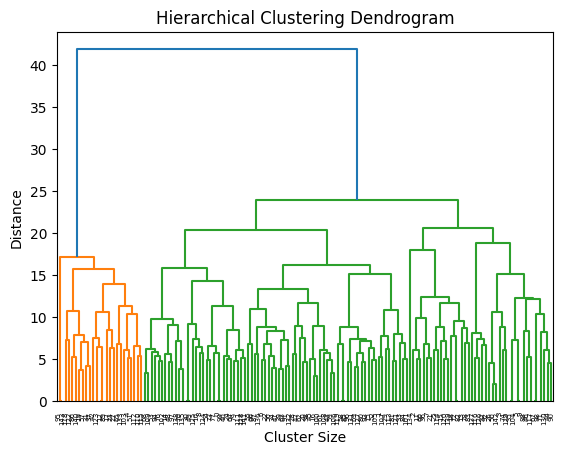

In [22]:
from scipy.cluster.hierarchy import dendrogram, linkage

# state the method of linkage you want
Z = linkage(new_df, method='ward', metric='euclidean')

# plots the dendrogram
dendrogram(Z)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Cluster Size")
plt.ylabel("Distance")
plt.grid(False)
plt.show()

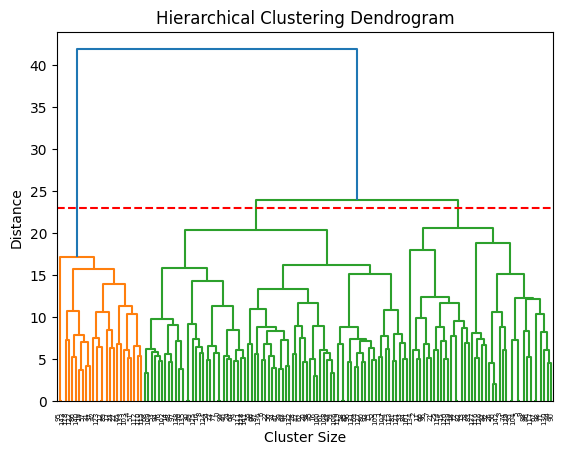

,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Z_CostContact,Z_Revenue,Response,Age,raw_total_spend,household_size,total_spend,MntWines_share,MntFruits_share,MntMeatProducts_share,MntFishProducts_share,MntSweetProducts_share,MntGoldProds_share,total_purchases,web_purchase_ratio,store_purchase_ratio,catalog_purchase_ratio,deal_intensity,customer_tenure_days,Education_2n Cycle,Education_Basic,Education_Graduation,Education_Master,Education_PhD,Marital_Status_Absurd,Marital_Status_Alone,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow,Marital_Status_YOLO,cluster
0,0.369237,-0.272315,-0.485383,-0.847862,0.744245,-0.613735,-1.214431,-0.449912,0.052240,-0.495132,-0.304855,0.585484,-0.038746,1.463446,-0.262435,0.0,0.0,0.907075,1.671283,-0.330729,-0.487566,-0.330729,1.331149,-0.577996,-1.349015,-0.328159,0.200036,-0.431104,1.135759,-0.075765,0.816125,-0.566406,-0.442401,1.298483,-0.328165,0.0,-1.150035,-0.377964,1.949359,-0.083624,0.0,-0.301511,-0.881917,1.909231,-0.534522,-0.189661,0.0,2
1,-0.128170,-0.272315,1.769300,1.556500,0.762295,0.437950,0.245300,-1.257700,-0.897202,1.523490,0.426798,2.428318,-0.835812,0.348440,0.719140,0.0,0.0,-1.102445,1.448789,0.592895,1.108106,0.592895,0.256603,0.290870,-0.018581,-1.254911,-0.917080,0.818518,0.913545,1.780947,-0.265462,-1.260295,0.047808,0.676632,-0.328165,0.0,-1.150035,2.645751,-0.512989,-0.083624,0.0,-0.301511,1.133893,-0.523771,-0.534522,-0.189661,0.0,2
2,0.350558,-0.272315,-0.485383,0.248244,-0.747880,1.163250,0.443488,0.878146,-0.458998,2.525096,-0.304855,-0.796642,1.156852,-0.394898,-1.244011,0.0,0.0,0.907075,-0.627826,0.266561,-0.487566,0.266561,-1.121023,1.195125,0.401663,0.738118,-0.505057,1.791618,0.024690,-0.932036,-0.549515,1.373033,-0.334330,-1.509876,-0.328165,0.0,0.869539,-0.377964,-0.512989,-0.083624,0.0,3.316625,-0.881917,-0.523771,-0.534522,-0.189661,0.0,3
3,0.831427,-0.272315,1.769300,-0.989295,-0.212400,-0.758795,-0.475037,1.494256,-0.751134,-0.602997,-0.304855,2.428318,1.555385,0.720109,0.719140,0.0,0.0,0.907075,-0.776155,-0.411818,1.108106,-0.411818,0.103901,-0.755064,-0.274740,2.003856,-0.659376,-0.516147,2.469042,0.734455,-0.771431,0.234959,-0.527507,-1.108682,3.047247,0.0,-1.150035,-0.377964,-0.512989,-0.083624,0.0,-0.301511,-0.881917,1.909231,-0.534522,-0.189661,0.0,3
4,-2.408015,-0.272315,1.769300,-1.555027,-1.403694,-0.903855,-1.511713,-1.257700,-1.134562,-0.664634,1.890103,0.124775,-2.031410,-0.766567,1.700716,0.0,0.0,0.907075,0.855470,-2.195778,1.108106,-2.195778,1.431609,-0.597488,-1.267147,-1.254911,-0.941432,0.672139,-1.530806,1.656688,0.464960,-2.128733,2.475509,-1.459727,-0.328165,0.0,0.869539,-0.377964,-0.512989,-0.083624,0.0,-0.301511,-0.881917,1.909231,-0.534522,-0.189661,0.0,1


In [23]:
# 3 main clusters at a distance of around 23. You can add a line as below

dendrogram(Z)
plt.axhline(y=23, color='red', linestyle='--')
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Cluster Size")
plt.ylabel("Distance")
plt.grid(False)
plt.show()

# You can convert the cut into cluster labels
from scipy.cluster.hierarchy import fcluster
cluster_labels = fcluster(Z, t=23, criterion='distance')
new_df['cluster'] = cluster_labels
new_df.head()

PCA

For PCA, the maximum number of principal components that can be computed is equal to the number of features in the dataset.

In this case, the dataset contains 47 columns, so PCA can produce up to 47 principal components.

When creating scree plots and cumulative variance plots, it is best practice to compute all available principal components first. This allows you to clearly see how much variance each component explains and decide on an optimal number of components to retain later.

47


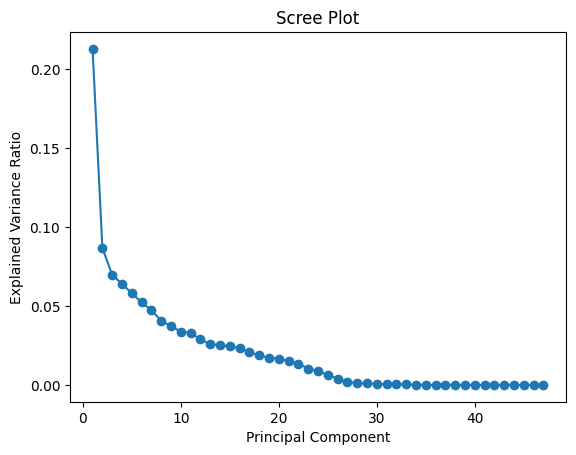

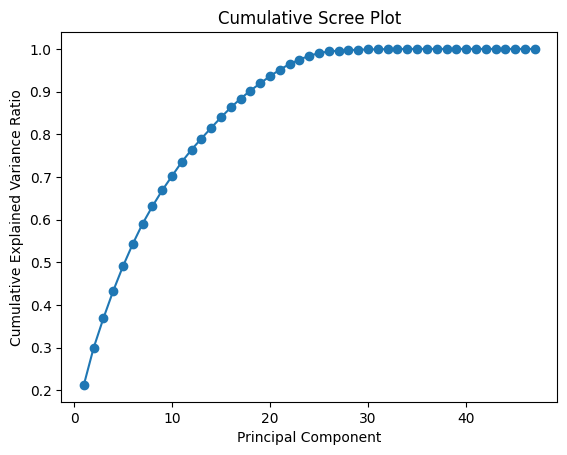

In [24]:
from sklearn.decomposition import PCA
import numpy as np

if 'cluster' in new_df.columns:
  new_df = new_df.drop('cluster', axis=1)

print(new_df.shape[1])

pca = PCA(n_components=new_df.shape[1]) # maximum number of components
pca.fit(new_df)

# Scree Plot
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_, marker='o')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.grid(False)
plt.show()

# Cumulative Plot
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Principal Component')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Scree Plot')
plt.grid(False)
plt.show()

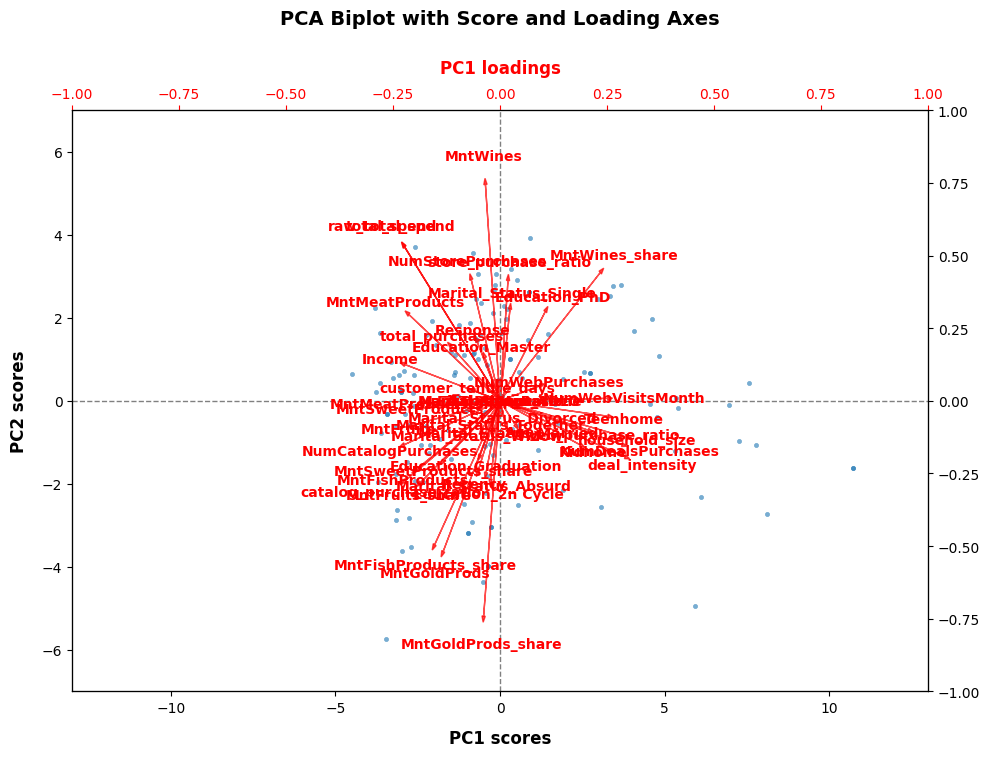

In [25]:
# Biplot
pcaX = pca.transform(new_df)[:, :2]   # first two principal components
loadings = pca.components_.T[:, :2]    # (n_features, 2)
feature_names = new_df.columns

fig, ax1 = plt.subplots(figsize=(10, 8)) # Create main figure and axis

# Plot data points in a scatter plot using our first two PCs as the axis
sc = ax1.scatter(
    pcaX[:, 0], pcaX[:, 1],
    s=10, alpha=0.6, linewidth=0.3
)

# Label your primary axis -> PCA scores
ax1.set_xlabel("PC1 scores", fontsize=12, fontweight='bold', labelpad=10)
ax1.set_ylabel("PC2 scores", fontsize=12, fontweight='bold', labelpad=10)
ax1.set_title("PCA Biplot with Score and Loading Axes", fontsize=14, fontweight='bold', pad=25)
ax1.grid(False)

# Create a secondary axis that records the loading of each feature in the original data set.
ax2 = ax1.twinx().twiny()
ax2.set_xlim(-1, 1)
ax2.set_ylim(-1, 1)
ax2.set_xlabel("PC1 loadings", fontsize=12, fontweight='bold', color='red', labelpad=10)
ax2.set_ylabel("PC2 loadings", fontsize=12, fontweight='bold', color='red', labelpad=10)
ax2.tick_params(axis='x', colors='red')
ax2.tick_params(axis='y', colors='red')
ax2.grid(False)

# Draw out the loading arrows.
scale = (np.max(np.abs(pcaX)) / np.max(np.abs(loadings))) * 0.5
for i, feature in enumerate(feature_names):
    ax1.arrow(0, 0, loadings[i, 0]*scale, loadings[i, 1]*scale,
              color='red', alpha=0.7, head_width=0.1, length_includes_head=True)
    ax1.text(loadings[i, 0]*scale*1.1, loadings[i, 1]*scale*1.1, feature,
             color='red', ha='center', va='center', fontsize=10, fontweight='bold')

# Add reference axis lines
ax1.axhline(0, color="gray", linestyle="--", linewidth=1)
ax1.axvline(0, color="gray", linestyle="--", linewidth=1)

# Formatting and Layout Code
xlim = ax1.get_xlim()
ylim = ax1.get_ylim()
x_pad = (xlim[1] - xlim[0]) * 0.15
y_pad = (ylim[1] - ylim[0]) * 0.15
ax1.set_xlim(-13,13)
ax1.set_ylim(-7,7)
plt.tight_layout(rect=[0, 0, 1, 0.96]) # adjust the plot so that title is visable

plt.show()

UMAP

To visualise the global structure of the data, choose a higher number of neighbours.

To visualise the local structure of data, choose a smaller number of neighbours.

However, choosing a higher number of neighbours does come with the trade off of longer computation time.

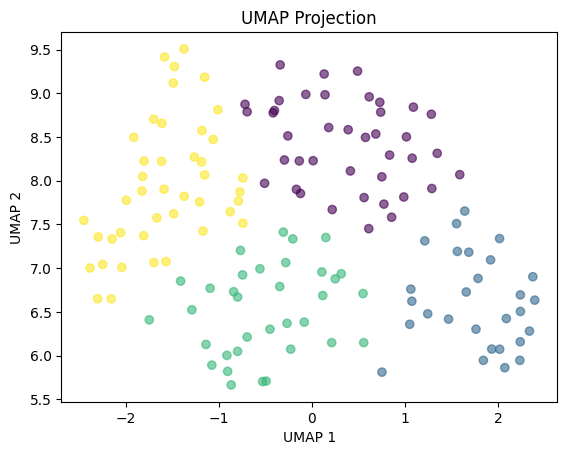

In [26]:
from umap import UMAP

umap = UMAP(n_neighbors=70, n_components=2, random_state=1000)
umap.fit(new_df)
umap_embedding = umap.transform(new_df)

kmeans = KMeans(n_clusters=4, random_state=1000) ## you can apply the same validation methods for kmeans here
clabels = kmeans.fit_predict(umap_embedding)

# visualising the plot
plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], alpha=0.6, c = clabels)
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.title("UMAP Projection")
plt.grid(False)
plt.show()

# LLM and Prompts

In [27]:
!pip install langchain langchain-core langchain-community langchain-huggingface huggingface_hub

# if using OpenAI's GPT LLMs install openai in place of hugginface_hub
# if using Anthropic's Claude LLMs install anthropic in place of huggingface_hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 48.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 3.8 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.4
    Uninstalling requests-2.32.4:
      Successfully uninstalled requests-2.32.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.


In [28]:
from langchain_core.prompts import PromptTemplate
from langchain_huggingface import HuggingFaceEndpoint , ChatHuggingFace
from google.colab import userdata

Generic Prompt

In [29]:
generic_prompt = PromptTemplate.from_template(
    '''
    You are an expert in world knowledge.
    Answer the following question thoroughly

    Question: What is a planet?
    '''
)

Content Grounding Prompt

In [30]:
content_grounding = PromptTemplate.from_template(
  '''
      You are an expert sales analyst.
      Task:
      Analyze and explain the observed trend described below.

      Data Usage Rules:
      - Use ONLY the data provided in the Data section.
      - Do NOT rely on external knowledge, assumptions, or general market trends.
      - If the data is insufficient to support a claim, state this explicitly.

      Data:
      {data}

      Output Format:
      1. Observed Trend
        - Briefly restate the trend using evidence from the data.
      2. Data-Driven Explanation
        - Explain the trend by referencing specific variables or statistics from the data.
      3. Limitations
        - Identify any constraints or missing information in the data that affect interpretation.

      Keep the response concise, factual, and grounded in the provided data.
      '''
)

In [31]:
## Based on your discretion, you might want to use scaled or unscaled data.

new_df_unscaled = df[df['AcceptedCmp1'] == 1]

new_df_unscaled = new_df_unscaled.drop(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Dt_Customer', 'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Complain'], axis =1)

new_df_unscaled.head()


,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Z_CostContact,Z_Revenue,Response,Age,raw_total_spend,household_size,total_spend,MntWines_share,MntFruits_share,MntMeatProducts_share,MntFishProducts_share,MntSweetProducts_share,MntGoldProds_share,total_purchases,web_purchase_ratio,store_purchase_ratio,catalog_purchase_ratio,deal_intensity,customer_tenure_days,Education_2n Cycle,Education_Basic,Education_Graduation,Education_Master,Education_PhD,Marital_Status_Absurd,Marital_Status_Alone,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow,Marital_Status_YOLO
15,82800.0,0,0,23,1006,22,115,59,68,45,1,7,6,12,3,3,11,1,80,1315,1,1315,0.764438,0.016717,0.087386,0.044833,0.051672,0.034195,25,0.269231,0.461538,0.230769,0.038462,4801,False,False,False,False,True,False,False,False,False,True,False,False,False
18,76995.0,0,1,91,1012,80,498,0,16,176,2,11,4,9,5,3,11,0,77,1782,2,1782,0.567583,0.044868,0.279305,0.000000,0.008974,0.098710,24,0.440000,0.360000,0.160000,0.080000,4677,False,False,False,True,False,False,False,False,True,False,False,False,False
53,82582.0,0,0,54,510,120,550,156,40,241,1,4,9,7,1,3,11,1,49,1617,1,1617,0.315204,0.074166,0.339926,0.096415,0.024722,0.148949,20,0.190476,0.333333,0.428571,0.047619,4241,False,False,True,False,False,False,False,True,False,False,False,False,False
67,88194.0,0,1,19,688,14,309,201,24,38,1,11,10,10,5,3,11,1,47,1274,2,1274,0.539608,0.010980,0.242353,0.157647,0.018824,0.029804,31,0.343750,0.312500,0.312500,0.031250,4321,True,False,False,False,False,False,False,False,False,True,False,False,False
87,50388.0,0,1,3,292,6,37,0,3,34,4,6,1,6,7,3,11,1,69,372,2,372,0.782842,0.016086,0.099196,0.000000,0.008043,0.091153,13,0.428571,0.428571,0.071429,0.285714,4251,False,False,True,False,False,False,False,False,False,True,False,False,False


In [32]:
stats = new_df_unscaled.describe().round(2)
print(stats) # visualise what describe does

bullets = []

for col in stats.columns:
    bullets.append(
        f"- {col}: "
        f"mean = {stats.loc['mean', col]}, "
        f"std = {stats.loc['std', col]}, "
        f"min = {stats.loc['min', col]}, "
        f"max = {stats.loc['max', col]}, "
        f"25% = {stats.loc['25%', col]}, "
        f"50% = {stats.loc['50%', col]}, "
        f"75% = {stats.loc['75%', col]}"
    )

stats_text = "\n".join(bullets)

          Income  Kidhome  Teenhome  Recency  MntWines  MntFruits  \
count     144.00   144.00    144.00   144.00    144.00     144.00   
mean    78490.81     0.09      0.22    46.98    758.60      55.85   
std     11711.26     0.33      0.45    28.38    333.57      55.34   
min     37929.00     0.00      0.00     1.00    152.00       0.00   
25%     72904.50     0.00      0.00    25.00    502.00      19.75   
50%     79767.00     0.00      0.00    45.50    761.50      29.50   
75%     85625.25     0.00      0.00    71.25   1006.75      87.75   
max    105471.00     2.00      2.00    99.00   1493.00     190.00   

       MntMeatProducts  MntFishProducts  MntSweetProducts  MntGoldProds  \
count           144.00           144.00            144.00        144.00   
mean            433.64            91.86             65.14         77.13   
std             263.29            73.29             54.96         65.12   
min              21.00             0.00              0.00          0.00   
25%

In [33]:
## For workshop purposes, observe the final prompt that will be sent to the LLM
print(content_grounding.format(data = stats_text))


      You are an expert sales analyst.
      Task:
      Analyze and explain the observed trend described below.

      Data Usage Rules:
      - Use ONLY the data provided in the Data section.
      - Do NOT rely on external knowledge, assumptions, or general market trends.
      - If the data is insufficient to support a claim, state this explicitly.

      Data:
      - Income: mean = 78490.81, std = 11711.26, min = 37929.0, max = 105471.0, 25% = 72904.5, 50% = 79767.0, 75% = 85625.25
- Kidhome: mean = 0.09, std = 0.33, min = 0.0, max = 2.0, 25% = 0.0, 50% = 0.0, 75% = 0.0
- Teenhome: mean = 0.22, std = 0.45, min = 0.0, max = 2.0, 25% = 0.0, 50% = 0.0, 75% = 0.0
- Recency: mean = 46.98, std = 28.38, min = 1.0, max = 99.0, 25% = 25.0, 50% = 45.5, 75% = 71.25
- MntWines: mean = 758.6, std = 333.57, min = 152.0, max = 1493.0, 25% = 502.0, 50% = 761.5, 75% = 1006.75
- MntFruits: mean = 55.85, std = 55.34, min = 0.0, max = 190.0, 25% = 19.75, 50% = 29.5, 75% = 87.75
- MntMeatProducts: m

Few Shot Prompt

In [34]:
from langchain_core.prompts import FewShotPromptTemplate
examples = [ #
    {
      "data": '''
        - Income: mean = 72,000
        - Kidhome: mean = 0.1
        - MntWines: mean = 680
        - MntMeatProducts: mean = 410
        - NumStorePurchases: mean = 7.5
        - NumWebPurchases: mean = 4.2
        ''',
        "profile": '''
        Customer Profile:
        Customers of these type are relatively high-income individuals with minimal household dependents.
        Spending is concentrated on premium food categories such as wine and meat, indicating a preference for quality products.
        Purchasing behavior shows a strong inclination toward in-store shopping, complemented by moderate online engagement.
        Overall, these customers appear value-driven rather than price-sensitive.
        '''
    },
    {
        "data" : '''
        - Income: mean = 34,500
        - Kidhome: mean = 1.2
        - MntWines: mean = 120
        - MntMeatProducts: mean = 160
        - NumStorePurchases: mean = 4.1
        - NumWebPurchases: mean = 1.8
        ''',
        "profile": '''
        Customer Profile:
        Customers in this segment tend to have lower household income and larger family responsibilities, as indicated by a higher average number of children at home.
        Spending on discretionary and premium food categories such as wine and meat is relatively limited, suggesting more budget-conscious purchasing behavior.
        Purchasing activity is less frequent overall, with a stronger reliance on physical stores compared to online channels.
        These customers appear more price-sensitive and focused on essential purchases rather than premium products.
        '''
    }
]

example_prompt = PromptTemplate.from_template(
    """
    Data:
    {data}

    Customer Profile:
    {profile}
    """
)

final_prompt = FewShotPromptTemplate(
    examples=examples,
    example_prompt=example_prompt,
    prefix="""
    You are an expert sales analyst.

    Task:
    Analyze the statistics and profile the customers that fall within this category.

    Data Usage Rules:
    - Use ONLY the data provided in the Data section.
    - Do NOT rely on external knowledge, assumptions, or general market trends.
    - If the data is insufficient to support a claim, state this explicitly.

    Output Format:
    Follow the format provided in the few-shot examples exactly.
    Do not deviate from the format.
    Keep the response concise, factual, and grounded in the provided data.
    """,
    suffix="""
    Data:
    {data}

    Customer Profile:
    """,
    input_variables=["data"]
)

In [35]:
print(final_prompt.format(data = stats_text))


    You are an expert sales analyst.

    Task:
    Analyze the statistics and profile the customers that fall within this category.

    Data Usage Rules:
    - Use ONLY the data provided in the Data section.
    - Do NOT rely on external knowledge, assumptions, or general market trends.
    - If the data is insufficient to support a claim, state this explicitly.

    Output Format:
    Follow the format provided in the few-shot examples exactly.
    Do not deviate from the format.
    Keep the response concise, factual, and grounded in the provided data.
    


    Data:
    
        - Income: mean = 72,000
        - Kidhome: mean = 0.1
        - MntWines: mean = 680
        - MntMeatProducts: mean = 410
        - NumStorePurchases: mean = 7.5
        - NumWebPurchases: mean = 4.2
        

    Customer Profile:
    
        Customer Profile:
        Customers of these type are relatively high-income individuals with minimal household dependents.
        Spending is concentrated on 

Chain-of-Thought Prompt

In [36]:
CoT_prompt = PromptTemplate.from_template(
    '''
    You are an expert sales analyst.

    Task:
    Analyze the following customer data and identify any notable trends or patterns.
    Base your analysis strictly on the data provided and avoid assumptions or external knowledge.

    Approach:
    Systematically evaluate the following factors:
    1. Demand-side drivers (e.g., product spending, household composition, etc.)
    2. Pricing and promotion effects (e.g., NumDealsPurchases, accepted offers, etc.)
    3. Seasonal or timing influences (e.g., Recency, etc.)
    4. Customer behavior changes (e.g., channel usage like NumWebPurchases, NumStorePurchases, etc.)
    5. External or market-related factors only if evident in the data

    For each factor:
    - Examine the relevant data points
    - Explain how they contribute to observed patterns

    Format:
    1. Observed Trend
      - Briefly restate the trend using evidence from the data.
    2. Data-Driven Explanation
      - Explain the trend by referencing specific variables or statistics from the data, using the specified factors above to explain your reasoning.
    3. Limitations
      - Identify any constraints or missing information in the data that affect interpretation.

    Conclude with a concise summary that integrates the key drivers and highlights the most notable trends.

    Data:
    {data}

    '''
)

In [37]:
print(CoT_prompt.format(data = stats_text))


    You are an expert sales analyst.

    Task:
    Analyze the following customer data and identify any notable trends or patterns.
    Base your analysis strictly on the data provided and avoid assumptions or external knowledge.

    Approach:
    Systematically evaluate the following factors:
    1. Demand-side drivers (e.g., product spending, household composition, etc.)
    2. Pricing and promotion effects (e.g., NumDealsPurchases, accepted offers, etc.)
    3. Seasonal or timing influences (e.g., Recency, etc.)
    4. Customer behavior changes (e.g., channel usage like NumWebPurchases, NumStorePurchases, etc.)
    5. External or market-related factors only if evident in the data

    For each factor:
    - Examine the relevant data points
    - Explain how they contribute to observed patterns

    Format:
    1. Observed Trend
      - Briefly restate the trend using evidence from the data.
    2. Data-Driven Explanation
      - Explain the trend by referencing specific variables

Directional Stimulus Prompt

In [38]:
DSP_prompt = PromptTemplate.from_template(
    '''
    You are an expert sales analyst.

    Your task is to describe a customer cluster based ONLY on the data provided.
    Do not use external knowledge or assumptions.

    IMPORTANT:
    You MUST base your analysis on the following keyword groups.
    Each section of your response must explicitly reference at least ONE variable name from the group.

    === PEOPLE FACTORS ===
    (Income, Kidhome, Teenhome, Recency)

    === PRODUCT SPEND ===
    (MntWines, MntFruits, MntMeatProducts, MntFishProducts, MntSweetProducts, MntGoldProds)

    === PROMOTION RESPONSE ===
    (NumDealsPurchases, Response)

    === PURCHASE CHANNEL ===
    (NumWebPurchases, NumCatalogPurchases, NumStorePurchases, NumWebVisitsMonth)

    === OTHER METRICS ===
    (Z_CostContact, Z_Revenue)

    DIRECTIVES:
    1. Organize your analysis into exactly FIVE sections, one per keyword group above.
    2. In each section:
      - Cite at least one specific variable by name
      - Explain what it tells us about this cluster
    3. Do NOT mention variables outside the listed keywords.
    4. Avoid general marketing theory — all claims must be tied to the data.

    Conclude with a single sentence summarizing the defining characteristics of this cluster.

    Cluster Data:
    {data}
'''
)

In [39]:
# Note: Make sure you've run the hierarchical clustering section first to generate cluster_labels
new_df_unscaled['Cluster'] = cluster_labels ## add cluster labels, since there was no shuffling of the dataframe. this should still work
new_df_unscaled.head()

,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Z_CostContact,Z_Revenue,Response,Age,raw_total_spend,household_size,total_spend,MntWines_share,MntFruits_share,MntMeatProducts_share,MntFishProducts_share,MntSweetProducts_share,MntGoldProds_share,total_purchases,web_purchase_ratio,store_purchase_ratio,catalog_purchase_ratio,deal_intensity,customer_tenure_days,Education_2n Cycle,Education_Basic,Education_Graduation,Education_Master,Education_PhD,Marital_Status_Absurd,Marital_Status_Alone,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow,Marital_Status_YOLO,Cluster
15,82800.0,0,0,23,1006,22,115,59,68,45,1,7,6,12,3,3,11,1,80,1315,1,1315,0.764438,0.016717,0.087386,0.044833,0.051672,0.034195,25,0.269231,0.461538,0.230769,0.038462,4801,False,False,False,False,True,False,False,False,False,True,False,False,False,2
18,76995.0,0,1,91,1012,80,498,0,16,176,2,11,4,9,5,3,11,0,77,1782,2,1782,0.567583,0.044868,0.279305,0.000000,0.008974,0.098710,24,0.440000,0.360000,0.160000,0.080000,4677,False,False,False,True,False,False,False,False,True,False,False,False,False,2
53,82582.0,0,0,54,510,120,550,156,40,241,1,4,9,7,1,3,11,1,49,1617,1,1617,0.315204,0.074166,0.339926,0.096415,0.024722,0.148949,20,0.190476,0.333333,0.428571,0.047619,4241,False,False,True,False,False,False,False,True,False,False,False,False,False,3
67,88194.0,0,1,19,688,14,309,201,24,38,1,11,10,10,5,3,11,1,47,1274,2,1274,0.539608,0.010980,0.242353,0.157647,0.018824,0.029804,31,0.343750,0.312500,0.312500,0.031250,4321,True,False,False,False,False,False,False,False,False,True,False,False,False,3
87,50388.0,0,1,3,292,6,37,0,3,34,4,6,1,6,7,3,11,1,69,372,2,372,0.782842,0.016086,0.099196,0.000000,0.008043,0.091153,13,0.428571,0.428571,0.071429,0.285714,4251,False,False,True,False,False,False,False,False,False,True,False,False,False,1


In [40]:
cluster_agg = new_df_unscaled.groupby('Cluster').mean()
cluster_agg.head()

,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Z_CostContact,Z_Revenue,Response,Age,raw_total_spend,household_size,total_spend,MntWines_share,MntFruits_share,MntMeatProducts_share,MntFishProducts_share,MntSweetProducts_share,MntGoldProds_share,total_purchases,web_purchase_ratio,store_purchase_ratio,catalog_purchase_ratio,deal_intensity,customer_tenure_days,Education_2n Cycle,Education_Basic,Education_Graduation,Education_Master,Education_PhD,Marital_Status_Absurd,Marital_Status_Alone,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow,Marital_Status_YOLO
Cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,64587.740000,0.440000,0.880000,39.800000,732.280000,9.800000,165.840000,25.880000,16.200000,45.560000,3.680000,6.680000,3.440000,7.000000,6.440000,3.0,11.0,0.440000,58.120000,995.560000,2.320000,995.560000,0.742364,0.009980,0.158162,0.023177,0.014069,0.050891,17.120000,0.366925,0.389386,0.184271,0.218887,4471.640000,0.040000,0.0,0.600000,0.040000,0.320000,0.00000,0.0,0.120000,0.560000,0.160000,0.160000,0.000000,0.0
2,81044.993506,0.012987,0.103896,47.350649,898.519481,60.272727,549.584416,98.168831,71.246753,67.233766,0.974026,5.519481,6.272727,8.636364,2.961039,3.0,11.0,0.545455,56.142857,1745.025974,1.116883,1745.025974,0.517895,0.032641,0.312919,0.056292,0.041943,0.037704,20.428571,0.256923,0.401913,0.292695,0.047389,4526.103896,0.012987,0.0,0.571429,0.168831,0.246753,0.00000,0.0,0.025974,0.402597,0.272727,0.298701,0.000000,0.0
3,82083.761905,0.023810,0.023810,50.571429,517.761905,75.142857,380.476190,119.571429,83.071429,114.071429,0.880952,5.547619,7.357143,7.642857,2.857143,3.0,11.0,0.619048,59.500000,1290.095238,1.047619,1290.095238,0.393465,0.055741,0.298978,0.091144,0.065677,0.094132,20.547619,0.257536,0.351112,0.342976,0.043228,4613.285714,0.285714,0.0,0.547619,0.095238,0.071429,0.02381,0.0,0.166667,0.428571,0.142857,0.119048,0.119048,0.0


In [41]:
cluster_texts = []

for cluster_id in cluster_agg.index:
    cluster_data = cluster_agg.loc[cluster_id]

    # Convert the cluster numeric stats into bullet text
    cluster_text = f'''
      Cluster {cluster_id} Data:
      - Income: mean = {cluster_data['Income']:.2f}
      - Kidhome: mean = {cluster_data['Kidhome']:.2f}
      - Teenhome: mean = {cluster_data['Teenhome']:.2f}
      - Recency: mean = {cluster_data['Recency']:.2f}

      - MntWines: mean = {cluster_data['MntWines']:.2f}
      - MntFruits: mean = {cluster_data['MntFruits']:.2f}
      - MntMeatProducts: mean = {cluster_data['MntMeatProducts']:.2f}
      - MntFishProducts: mean = {cluster_data['MntFishProducts']:.2f}
      - MntSweetProducts: mean = {cluster_data['MntSweetProducts']:.2f}
      - MntGoldProds: mean = {cluster_data['MntGoldProds']:.2f}

      - NumDealsPurchases: mean = {cluster_data['NumDealsPurchases']:.2f}
      - Response: mean = {cluster_data['Response']:.2f}

      - NumWebPurchases: mean = {cluster_data['NumWebPurchases']:.2f}
      - NumCatalogPurchases: mean = {cluster_data['NumCatalogPurchases']:.2f}
      - NumStorePurchases: mean = {cluster_data['NumStorePurchases']:.2f}
      - NumWebVisitsMonth: mean = {cluster_data['NumWebVisitsMonth']:.2f}

      - Z_CostContact: mean = {cluster_data['Z_CostContact']:.2f}
      - Z_Revenue: mean = {cluster_data['Z_Revenue']:.2f}
      '''
    # Add this cluster's text to the list
    cluster_texts.append(cluster_text)

cluster_info = "\n".join(cluster_texts)

In [42]:
print(DSP_prompt.format(data = cluster_info))


    You are an expert sales analyst.

    Your task is to describe a customer cluster based ONLY on the data provided.
    Do not use external knowledge or assumptions.

    IMPORTANT:
    You MUST base your analysis on the following keyword groups.
    Each section of your response must explicitly reference at least ONE variable name from the group.

    === PEOPLE FACTORS ===
    (Income, Kidhome, Teenhome, Recency)

    === PRODUCT SPEND ===
    (MntWines, MntFruits, MntMeatProducts, MntFishProducts, MntSweetProducts, MntGoldProds)

    === PROMOTION RESPONSE ===
    (NumDealsPurchases, Response)

    === PURCHASE CHANNEL ===
    (NumWebPurchases, NumCatalogPurchases, NumStorePurchases, NumWebVisitsMonth)

    === OTHER METRICS ===
    (Z_CostContact, Z_Revenue)

    DIRECTIVES:
    1. Organize your analysis into exactly FIVE sections, one per keyword group above.
    2. In each section:
      - Cite at least one specific variable by name
      - Explain what it tells us about this

#Setting up your LLM#

To obtain and utilise Hugging Face API key, follow the following steps:

Assuming you already set up an account,


Get a Hugging Face API token
1.   Go to https://huggingface.co/settings/tokens
2.   Remember to confirm your email
3.   Click "New token" and create a token with "Read" access
4.   Copy the token (take note that you will **only be shown your token once**)

Add Token to Colab

1. Click the key icon on the side bar
2. Click "Add new secret"
   - Name: HF_TOKEN
   - Value: Paste your token
   - Enable "Notebook access"



In [43]:
try: ## Double check that you have set up your HF API token first
    HF_TOKEN = userdata.get('HF_TOKEN')
    if HF_TOKEN is None:
        raise ValueError
except:
    raise ValueError("Please set up HF_TOKEN in Colab secrets")

model = HuggingFaceEndpoint(
    repo_id="mistralai/Mistral-7B-Instruct-v0.2", ## find the model that you want to use from HuggingFace
    max_new_tokens = 512, ## The number of tokens that the LLM is allowed to generate in its response
    temperature = 0, ## 0 = deterministic/consistent output, higher = more creative/random
    huggingfacehub_api_token=HF_TOKEN ## your api key to send requests
)

llm = ChatHuggingFace(llm = model) ## This is a Chat Wrapper to ensure that the LLM is able to engage in a conversation

Generic Prompt Response

In [44]:
response = llm.invoke(generic_prompt.format())
# response is an object with multiple fields, e.g.: metadata, content...
print(response.content)
# response

 A planet is a celestial body that orbits a star, typically large enough to be rounded by its own gravity, and distinct from its orbiting moons. Planets are considered to be the smallest objects in the solar system that can be classified as planets, as they have cleared their orbits of other debris and have a spherical shape due to their self-gravity.

Planets are divided into two main categories: terrestrial or telluric planets, and gas giants. Terrestrial planets are smaller in size, with solid surfaces and a solid inner structure, consisting primarily of silicate rocks or metals, and include Mercury, Venus, Earth, and Mars. Gas giants, on the other hand, are much larger, have a gaseous composition, and have no solid surface. They include Jupiter, Saturn, Uranus, and Neptune.

In 2006, the International Astronomical Union (IAU) updated its definition of a planet as follows:

1. A planet is a celestial body that is in orbit around the sun,
2. has enough mass for its self-gravity to ma

Content Grounding Response

In [45]:
response = llm.invoke(content_grounding.format(data = stats_text))
print(response.content)

 1. Observed Trend:
The data indicates that the average total spend and the average number of purchases per customer are moderate, with the mean total spend being $1482.22 and the mean number of purchases being 19.89. Customers primarily shop in stores, with a mean ratio of 0.38, followed by catalogs (0.29) and the web (0.28). The average income is relatively high, at $78,490.81.

2. Data-Driven Explanation:
The observed trend can be explained by the following factors:

- Moderate total spend: With the average income being moderately high, the average total spend is also moderate. Customers tend to purchase a mix of product categories, which keeps the total spend within a reasonable range.
- Preference for physical stores: The mean ratio of store purchases (0.38) is higher than that of web or catalog purchases, indicating a preference for in-person shopping. This could be due to various reasons, such as personal preference, convenience, or the broader product selection offered in store

Few-shot Prompt Response

In [46]:
response = llm.invoke(final_prompt.format(data = stats_text))
print(response.content)

 Customer Profile:
Customers in this segment have an average income of $78,491 with a standard deviation of $11,711, making them high-income individuals. The average number of children at home (Kidhome) and teenagers (Teenhome) are both minimal, with means of 0.09 and 0.22 respectively.

The average customer purchases from the store 8.06 times, with a standard deviation of 2.7 and a range from 4 to 13. They make 5.73 web purchases on average, with a standard deviation of 2.18 and a range from 2 to 11. The average customer age is 57.47 years old, and their total annual spend is $1482.22, with a standard deviation of $507.38 and a range from $265 to $2524.

The composition of their purchasing behavior reveals a significant interest in food products. They spend 52.0% of their budget on wine-related items (MntWines), 6.0% on fruit products (MntFruits), 28.0% on meat products (MntMeatProducts), and 6.0% on fish products (MntFishProducts), amongst others. Their spending on gold products (Mnt

Chain of Thought Response

In [47]:
response = llm.invoke(CoT_prompt.format(data = stats_text ))
print(response.content)

 Observed Trend:
The data shows that the mean household income is relatively high at 78490.81, and the share of spending on certain product categories like Wines (MntWines), Fruits (MntFruits), Meat Products (MntMeatProducts), Fish Products (MntFishProducts),Sweet Products (MntSweetProducts), and Gold Products (MntGoldProds) varies significantly. The ratio of web purchases (web_purchase_ratio), store purchases (store_purchase_ratio), and catalog purchases (catalog_purchase_ratio) also varies among customers.

Data-Driven Explanation:
1. Household income: A higher income might be a demand-side driver for customers to spend more on certain product categories, hence the observed variations in product shares (MntWines_share, MntFruits_share, etc.). However, the limitations include that this data does not indicate which customers have increasing or decreasing incomes.
2. Product spending: The differences in average spending (MntWines, MntFruits, MntMeatProducts, etc.) and their respective s

Direct Stimulus Prompt Response


In [48]:
response = llm.invoke(DSP_prompt.format(data = cluster_info))
print(response.content)

 Section 1: People Factors
-----------

The Income variable in Cluster 1 has a mean of 64587.74, indicating a lower income level for this customer cluster compared to the other clusters. Moreover, the Recency mean of 39.80 suggests that these customers are relatively new to our business.

Section 2: Product Spend
-----------

Customers in Cluster 1 have a lower expenditure on various product categories. Their MntMeatProducts mean of 165.84 and MntFishProducts mean of 25.88 are significantly lower than in Cluster 2 or 3. Also, the MntSweetProducts mean of 16.20 implies that they spend relatively less on sweet products.

Section 3: Promotion Response
-----------

Customers in Cluster 1 have a lower involvement in purchasing deals and have a neutral response to deals, suggesting that these are price-sensitive customers. Their average NumDealsPurchases is 3.68 with a Response mean of 0.44.

Section 4: Purchase Channel
-----------

Customers in Cluster 1 show a preference for online shoppin

# Text Analysis

In [49]:
customer_texts = [
    """
    I usually purchase wine and meat products from the store.
    I don't buy very often unless there are discounts available.
    I rarely shop online and prefer visiting physical stores.
    Prices have gone up recently so I try to limit my spending.
    """,

    """
    Most of my purchases are made through the website.
    I buy wine regularly and occasionally purchase gold products.
    Promotions influence my buying decisions and I often wait for deals.
    I tend to shop more frequently compared to the past.
    """,

    """
    I mainly shop for fruits and fish products for my household.
    With kids at home, I focus on essential items and avoid premium products.
    I purchase both online and in-store depending on convenience.
    I do not usually respond to marketing promotions.
    """,

    """
    I have not made many purchases recently.
    I mostly browse the website but rarely complete a purchase.
    Prices feel high and I am unsure if the products offer good value.
    I only buy when necessary.
    """
]

In [50]:
summarization_prompt = PromptTemplate.from_template("""
Task: Summarize the following customer feedback.

Rules:
- Use ONLY the information in the text
- Neutral, factual tone
- Maximum 2 sentences
- Do NOT add assumptions

Customer Text:
{text}

Summary:
""")

def summarize_with_confidence(text):
    summary = llm.invoke(
        summarization_prompt.format(text=text)
    ).content

    # simple confidence proxy
    signal_words = ["buy", "purchase", "shop", "discount", "online", "store", "price"]
    evidence_count = sum(word in text.lower() for word in signal_words)

    confidence = min(0.9, 0.3 + 0.1 * evidence_count)

    return summary, round(confidence, 2)

In [51]:
classification_prompt = PromptTemplate.from_template("""
Task: Classify the customer based on the text.

Rules:
- Use ONLY the text
- Choose ONE label per category
- If unclear, choose "Unknown"

Categories:
1. Spending Level: [Low, Medium, High, Unknown]
2. Price Sensitivity: [Low, Medium, High, Unknown]
3. Preferred Channel: [Online, Store, Mixed, Unknown]

Customer Text:
{text}

Output (JSON ONLY):
{{
  "spending_level": "",
  "price_sensitivity": "",
  "preferred_channel": ""
}}
""")

def classify_with_confidence(text):
    result = llm.invoke(
        classification_prompt.format(text=text)
    ).content

    signals = {
        "spending": ["rarely", "often", "frequently", "limit", "regularly"],
        "price": ["price", "discount", "deal", "expensive"],
        "channel": ["online", "store", "website"]
    }

    evidence = sum(
        any(word in text.lower() for word in words)
        for words in signals.values()
    )

    confidence = min(0.9, 0.4 + 0.15 * evidence)

    return result, round(confidence, 2)

In [52]:
extraction_prompt = PromptTemplate.from_template("""
Task: Extract factual information explicitly stated in the text.

Rules:
- Extract ONLY what is mentioned
- Do NOT infer or guess
- Use null if not stated

Fields:
- mentioned_products (list)
- mentions_discounts (true/false)
- mentions_price_concern (true/false)
- purchase_channel

Customer Text:
{text}

Output (JSON ONLY):
{{
  "mentioned_products": [],
  "mentions_discounts": null,
  "mentions_price_concern": null,
  "purchase_channel": null
}}
""")

def extract_with_confidence(text):
    extraction = llm.invoke(
        extraction_prompt.format(text=text)
    ).content

    keywords = ["wine", "meat", "fish", "fruit", "gold", "discount", "price", "online", "store"]
    evidence = sum(word in text.lower() for word in keywords)

    confidence = min(0.95, 0.35 + 0.08 * evidence)

    return extraction, round(confidence, 2)

In [53]:
for i, text in enumerate(customer_texts, 1):
    print(f"\n=== CUSTOMER {i} ===")

    summary, s_conf = summarize_with_confidence(text)
    print("SUMMARY:", summary)
    print("Summary Confidence:", s_conf)

    classification, c_conf = classify_with_confidence(text)
    print("CLASSIFICATION:", classification)
    print("Classification Confidence:", c_conf)

    extraction, e_conf = extract_with_confidence(text)
    print("EXTRACTION:", extraction)
    print("Extraction Confidence:", e_conf)


=== CUSTOMER 1 ===
SUMMARY:  The customer frequently buys wine and meat products from the store but only makes purchases when discounts are offered. They seldom shop online and prefer physical stores, yet increasing prices have led them to restrict their spending.
Summary Confidence: 0.9
CLASSIFICATION:  {
  "spending_level": "Medium",
  "price_sensitivity": "Medium",
  "preferred_channel": "Store"
}
Classification Confidence: 0.85
EXTRACTION:  {
  "mentioned_products": ["wine", "meat"],
  "mentions_discounts": null,
  "mentions_price_concern": true,
  "purchase_channel": null
}

Explanation: The text mentions the products 'wine' and 'meat' that the customer purchases. There is no explicit mention of discounts, but the text states that the customer only shops 'unless there are discounts available'. However, this is an implication and not an explicit statement, so it is marked as null. The text states that the customer's prices have gone up, and they try to limit their spending, so it 